In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sbi.inference import NPE
import torch


# Generate random input signal
num_samples = 100
t_max = 10
num_timesteps = 64

np.random.seed(4)

# Generate random input signal
x_data = np.abs(np.cumsum(np.random.rand(num_samples, num_timesteps, 1) - 0.5, axis=1))
t_data = np.linspace(0, t_max, num_timesteps)

# Interpolate input signal to match time resolution
t = np.linspace(0, t_max, 500)
input_signal = np.interp(t, t_data, x_data[0, :, 0])

# Define system of equations
def mass_spring_damper(y, t, m, k, b, input_signal):
    x, v = y
    F = np.interp(t, t_data, x_data[0, :, 0])
    dxdt = v
    dvdt = (F - b * v - k * x) / m
    return [dxdt, dvdt]

2025-03-27 09:59:19.104804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743065959.156252    5301 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743065959.170950    5301 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743065959.285403    5301 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743065959.285422    5301 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743065959.285423    5301 computation_placer.cc:177] computation placer alr

In [10]:

def mass_spring_damper_simulator(params):
    m, k, b = params
    t = np.linspace(0, 10, num_timesteps)  # Simulation time steps
    
    # Generate positive or non-negative input force
    F = np.cumsum(np.random.rand(num_timesteps) - 0.25)
    F = np.maximum(F, 0)

    # Solve the system
    x0 = [0, 0]  # Initial position and velocity
    sol = odeint(mass_spring_damper, x0, t, args=(m, k, b, F))

    # Extract state variables
    x = sol[:, 0]
    v = sol[:, 1]

    # Get summary statistics
    stats = extract_summary_statistics(t, x, v)

    return stats

def extract_summary_statistics(t, x, v):
    steady_state = x[-1]

    # Settling time
    settling_idx = np.where(np.abs(x - steady_state) <= 0.05 * np.abs(steady_state))[0]
    settling_time = t[settling_idx[0]] if len(settling_idx) > 0 else np.nan

    # Rise time (time to go from 10% to 90% of final value)
    try:
        rise_start = np.where(x >= 0.1 * steady_state)[0][0]
        rise_end = np.where(x >= 0.9 * steady_state)[0][0]
        rise_time = t[rise_end] - t[rise_start]
    except IndexError:
        rise_time = np.nan

    # Peak overshoot
    peak_overshoot = (np.max(x) - steady_state) / steady_state if steady_state != 0 else np.nan

    # Final position and velocity
    final_position = x[-1]
    final_velocity = v[-1]

    # Mean and variance of position and velocity (to handle randomness)
    mean_position = np.mean(x)
    var_position = np.var(x)
    mean_velocity = np.mean(v)
    var_velocity = np.var(v)
    energy = np.sum(x**2)
    max_rate_of_change = np.max(np.diff(x) / np.diff(t))

    # Combine all summary stats into a single vector
    summary_stats = np.array([
        settling_time, rise_time, peak_overshoot,
        final_position, final_velocity,
        mean_position, var_position,
        mean_velocity, var_velocity,
        energy, max_rate_of_change
    ])
    
    # Handle any NaNs with a fallback value (e.g., -1 or zero)
    summary_stats = np.nan_to_num(summary_stats, nan=-1)

    return summary_stats

# Prior distribution for (m, k, b) — assuming you know rough ranges
prior = torch.distributions.Uniform(low=torch.tensor([0.1, 0.1, 0.1]),
                                    high=torch.tensor([10.0, 10.0, 10.0]))

# Convert the simulator to a PyTorch-compatible function
simulator = lambda params: torch.tensor(mass_spring_damper_simulator(params.numpy()), dtype=torch.float32)

# Create inference object
inference = NPE(prior)

# Generate training data
theta, x = [], []
num_simulations = 5000
for _ in range(num_simulations):
    params = prior.sample().numpy()
    theta.append(params)
    x.append(mass_spring_damper_simulator(params))

theta = torch.tensor(theta, dtype=torch.float32)
x = torch.tensor(x, dtype=torch.float32)

# Train the inference network
density_estimator = inference.append_simulations(theta, x).train()

# Build posterior
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 336 epochs.

In [11]:
# Observe a new system response
observed_data = mass_spring_damper_simulator([1.0, 8.0, 0.8])
observed_data = torch.tensor(observed_data, dtype=torch.float32)
# Infer parameters
samples = posterior.sample((1000,), x=observed_data)
m_inferred, k_inferred, b_inferred = samples.mean(dim=0)
print(f"Inferred m, k, b: {m_inferred}, {k_inferred}, {b_inferred}")

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Inferred m, k, b: 1.0731205940246582, 7.919112205505371, 0.865809977054596


In [14]:
sample = prior.sample((1,))
observed_data_2 = mass_spring_damper_simulator(sample.numpy()[0])
observed_data_2 = torch.tensor(observed_data_2, dtype=torch.float32)
# Infer parameters
samples_2 = posterior.sample((1000,), x=observed_data_2)
m_inferred_2, k_inferred_2, b_inferred_2 = samples_2.mean(dim=0)
print(f"Sampled  m, k, b: {sample[0][0]}, {sample[0][1]}, {sample[0][2]}")
print(f"Inferred m, k, b: {m_inferred_2}, {k_inferred_2}, {b_inferred_2}")

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampled  m, k, b: 8.956321716308594, 5.260850429534912, 7.6576714515686035
Inferred m, k, b: 8.924392700195312, 5.273158550262451, 7.623307228088379


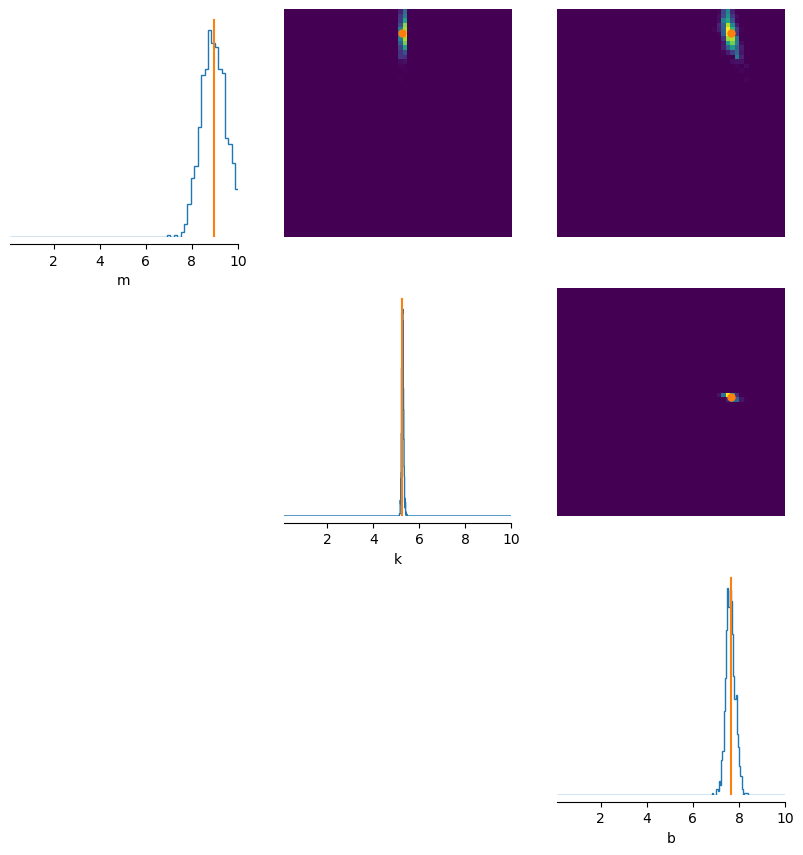

In [15]:
from sbi import analysis

fig, ax = analysis.pairplot(
    samples_2,
    points=sample,
    labels=["m", "k", "b"],
    limits=[[0.1, 10.0], [0.1, 10.0], [0.1, 10.0]]  # Prior limits for m, k, b
)

In [7]:
import pickle
with open(f"./models/msd_summary_statistics_{num_simulations}.pkl", "wb") as handle:
    pickle.dump(posterior, handle)